In [1]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from keras import layers
import numpy as np
import cv2

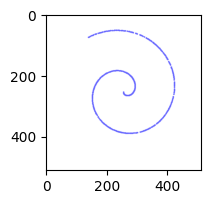

In [173]:
#визуализация
def viz(tensor):
    tensor = tensor.numpy()
    x = tensor[:, 0]/3
    y = tensor[:, 1]/3
    screen = np.ones((512, 512, 3), dtype = np.float32)
    for i in range(x.shape[0]):
        screen = cv2.circle(screen, (int(x[i]*256+ 256), int(y[i]*256 + 256)), 1, (0.4,0.4,1), 2)
    return screen

#генерируем массив исходных точек
tensor = tf.stack([tf.random.uniform([1000], 1, 2), tf.random.uniform([1000], 1, 2)], axis = 1)

#еще идеи интересных распределений

#граффик функции
tensora = tf.random.uniform([1000], 0, 10)
tensorx = tf.sin(tensora)*tensora/4
tensory = tf.cos(tensora)*tensora/4
tensor = tf.stack([tensorx, tensory], axis = 1)

#два прямоугольника
#tensor1 = tf.stack([tf.random.uniform([300], 0.2, 0.5), tf.random.uniform([300], -1.8, 0)], axis = 1)
#tensor2 = tf.stack([tf.random.uniform([300], -2, -0.3), tf.random.uniform([300], 2, 2.3)], axis = 1)
#tensor3 = tf.stack([tf.random.uniform([400], -1, -0.4), tf.random.uniform([400], -1, 1)], axis = 1)
#tensor = tf.concat([tensor1, tensor2, tensor3], axis = 0)

screen = viz(tensor)
plt.figure(figsize = (2,6))
plt.subplot(1,1,1)
plt.imshow(screen)


plt.show()

In [167]:
from tensorflow.keras.layers import Dense, Reshape, Dropout, Input, Concatenate
from tensorflow.keras.models import Model

#делаем простую нейросеть регрессор (выход без активации)
#два входа: координаты и время(уровень шума)

inputs = Input((2,))
noise_level = Input((1,))

x = Concatenate()([inputs, noise_level])
x = Dense(256, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(2)(x)

network = keras.Model([inputs, noise_level], x)

In [174]:
#оставляем небольшой зазор до 0 и 1 
min_signal_rate = 0.01
max_signal_rate = 0.99

class DiffusionModel(keras.Model):
    def __init__(self, network):
        super().__init__()
        self.network = network
        self.optimizer = tf.keras.optimizers.Adam(1e-3)
        
    def diffusion_schedule(self, diffusion_times):
        
        #расчет параметров
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)
        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)

        return noise_rates, signal_rates
    
    def denoise(self, noisy_signal, noise_rates, signal_rates):
        
        #предсказавыем весь шум, предсказанный нейросетью
        pred_noises = self.network([noisy_signal, noise_rates**2])
        
        #и находим чистые данные, удаляя шум так, будто шаг всего один
        pred_signal = (noisy_signal - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_signal
    
    def reverse_diffusion(self, initial_noise, diffusion_steps):
        
        num_signals = 1000
        #найдем размер шага
        step_size = 1.0 / diffusion_steps

        # на первом шаге "noisy image" чистый шум
        # но его signal rate должен быть ненулевым (min_signal_rate)
        
        next_noisy_signals = initial_noise
        
        result_base = []
        
        for step in range(diffusion_steps):
            noisy_signals = next_noisy_signals
            
            #время диффузии идет в обратную сторону (1 - step)
            diffusion_times = tf.ones((num_signals, 1)) - step * step_size
            
            #находим параметры
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            
            #предсказываем шум и сигнал без шума, 'разделяем' их
            pred_noises, pred_signals = self.denoise(noisy_signals, noise_rates, signal_rates)
           
            #если отнять stepsize, получим время для следующего шага
            next_diffusion_times = diffusion_times - step_size
            
            #считаем параметры (теперь значение шума меньше, значение сигнала больше)
            next_noise_rates, next_signal_rates = self.diffusion_schedule(next_diffusion_times)
            
            #и с новыми параметрами опять собираем зашумленный сигнал
            #из того-же шума и того-же сигнала
            next_noisy_signals = (next_signal_rates * pred_signals + next_noise_rates * pred_noises)
            
            
            #if step%(diffusion_steps / 100) == 0:
            result_base.append(next_noisy_signals)
        
        result_base.append(pred_signals)

        return result_base
    
    @tf.function
    def train_step(self, signals):
        
        noises = tf.random.normal(shape=(1000, 2))
       
        diffusion_times = tf.random.uniform(shape=(1000, 1), minval=0.0, maxval=1.0)
        
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)

        noisy_signals = signal_rates * signals + noise_rates * noises

        with tf.GradientTape() as tape:
        
            pred_noises, pred_images = self.denoise(noisy_signals, noise_rates, signal_rates)

            noise_loss = tf.reduce_mean(tf.abs(noises - pred_noises), axis = 1)


        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))
        
        return noise_loss
        
model = DiffusionModel(network)


эпоха 19
ошибка: 0.5939144492149353


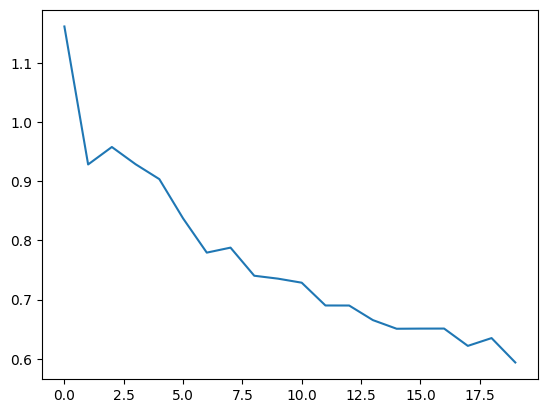

In [175]:
#обучаем
epochs = 20
hist = np.array(np.empty([0]))
from IPython.display import clear_output
for epoch in range(epochs): 
    
        loss = tf.reduce_mean(model.train_step(tensor), axis = 0)
        
        clear_output(wait=True)
        print('эпоха ' + str(epoch))
        print('ошибка: ' + str(float(loss)))
           
        hist = np.append(hist, float(loss))
        plt.plot(np.arange(0,len(hist)), hist)
        plt.show()

In [176]:
results = model.reverse_diffusion(tf.random.normal([1000, 2]), 100)

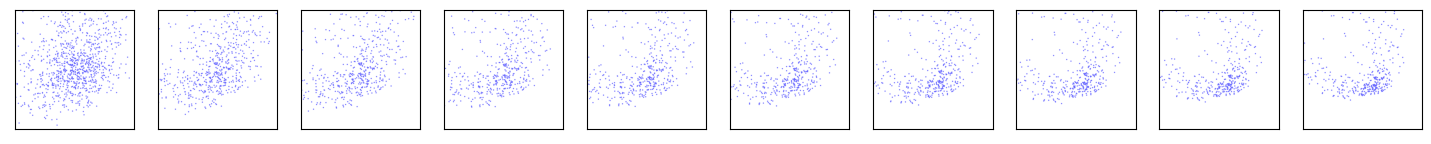

In [177]:
plt.figure(figsize = (20,20))
for i in range(10):
    screen = viz(results[i*10])

    plt.subplot(1,11,1 + i)
    plt.imshow(screen)
    
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [178]:
#красивая анимация визуализация
import time
screen = viz(results[0])
cv2.imshow('frame', screen)
cv2.waitKey(10000)

for i in range(101):
    screen = viz(results[i])
    cv2.imshow('frame', screen)
    if cv2.waitKey(10) == ord('q'):
        break
        
cv2.waitKey(3000)
cv2.destroyAllWindows()